# Lab 1d: K-Means Clustering Analysis of a Heart Failure Clinical Dataset
In this lab, we will cluster a dataset of clinical risk factors linked with death from heart disease using [the K-means clustering algorithm](https://en.wikipedia.org/wiki/K-means_clustering).

The dataset contains 299 patients with 13 features (continuous and categorical) and a binary clinical outcome `{death | not death}`. 

> __Learning Objectives__
> 
> By the end of this lab, you will be able to:
>
> * __Apply K-means clustering to clinical data:__ Implement K-means clustering on a heart disease dataset with mixed continuous and categorical features, including data preprocessing through binary recoding and z-score normalization.
> * __Validate clustering convergence through energy minimization:__ Compute and visualize the configuration energy of K-means clustering to verify that the algorithm converges to a stable state through iterative assignment and centroid updates.
> * __Interpret cluster composition and clinical patterns:__ Analyze cluster membership and centroid values to identify patterns in patient risk factors and assess whether feature similarity corresponds to clinical outcomes.

Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up the code environment:

In [1]:
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file

In addition to standard Julia libraries, we'll also use [the `VLDataScienceMachineLearningPackage.jl` package](https://github.com/varnerlab/VLDataScienceMachineLearningPackage.jl). Check out [the documentation](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/) for more information on the functions, types, and data used in this material.

### Data
Next, let's load up the dataset that we will explore. The data for this lab was taken from this `2020` publication:
* [Davide Chicco, Giuseppe Jurman: "Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone." BMC Medical Informatics and Decision Making 20, 16 (2020). https://doi.org/10.1186/s12911-020-1023-5](https://pubmed.ncbi.nlm.nih.gov/32013925/)

In this paper, the authors analyzed a dataset of 299 heart failure patients collected in 2015. The patients comprised 105 women and 194 men, aged between 40 and 95 years old. The dataset contains 13 features (a mixture of continuous and categorical data), which report clinical, body, and lifestyle information:
* Some features are binary: anemia, high blood pressure, diabetes, sex, and smoking status.
* The remaining features were continuous biochemical measurements, such as the level of the Creatinine phosphokinase (CPK) enzyme in the blood, the number of platelets, etc.
* The class (target) variable is encoded as a binary (boolean) death event: `1` if the patient died during the follow-up period, `0` if the patient did not die during the follow-up period.

We'll load this dataset as a [DataFrame instance](https://dataframes.juliadata.org/stable/) and store it in the `originaldataset::DataFrame` variable:

In [2]:
originaldataset = MyHeartDiseaseClinicalDataset(); # load the heart disease dataset

#### Data scaling
[K-means](https://en.wikipedia.org/wiki/K-means_clustering) requires [a `Matrix`](https://docs.julialang.org/en/v1/base/arrays/#Base.Matrix-Tuple{UndefInitializer,%20Any,%20Any}), not [a `DataFrame`](https://dataframes.juliadata.org/stable/). We preprocess the data in three steps:

> __Data Preprocessing:__
> 
> * __Binary recoding:__ Convert categorical `0,1` data to `-1,1` where `0` maps to `-1` and `1` remains `1`.
> * __Z-score normalization:__ Apply [z-score scaling](https://en.wikipedia.org/wiki/Feature_scaling) to continuous features using $x^{\prime} = (x - \mu)/\sigma$ where $\mu$ is the mean and $\sigma$ is the standard deviation.
> * __Label exclusion:__ Remove the `death_event` label to test whether feature similarity corresponds to clinical outcomes.

The preprocessed data is stored in `D::Matrix{Float64}`, while the treated dataset is in `dataset::DataFrame`.


In [3]:
(D, dataset) = let

    # convert 0,1 into -1,1
    treated_dataset = copy(originaldataset);
    transform!(treated_dataset, :anaemia => ByRow(x -> (x==0 ? -1 : 1)) => :anaemia); # maps anaemia to -1,1
    transform!(treated_dataset, :diabetes => ByRow(x -> (x==0 ? -1 : 1)) => :diabetes); # maps diabetes to -1,1
    transform!(treated_dataset, :high_blood_pressure => ByRow(x -> (x==0 ? -1 : 1)) => :high_blood_pressure); # maps high_blood_pressure to -1,1
    transform!(treated_dataset, :sex => ByRow(x -> (x==0 ? -1 : 1)) => :sex); # maps sex to -1,1
    transform!(treated_dataset, :smoking => ByRow(x -> (x==0 ? -1 : 1)) => :smoking); # maps smoking to -1,1
    transform!(treated_dataset, :death_event => ByRow(x -> (x==0 ? -1 : 1)) => :death_event); # maps death_event to -1,1
    
    D = treated_dataset[:,1:end] |> Matrix; # build a data matrix from the DataFrame
    (number_of_examples, number_of_features) = size(D);

    # Which cols do we want to rescale?
    index_to_z_scale = [
        1 ; # 1 age
        3 ; # 2 creatinine_phosphokinase
        5 ; # 3 ejection_fraction
        7 ; # 4 platelets
        8 ; # 5 serum_creatinine
        9 ; # 6 serum_sodium
        12 ; # 7 time
    ];

    D̂ = copy(D);
    for i ∈ eachindex(index_to_z_scale)
        j = index_to_z_scale[i];
        μ = mean(D[:,j]); # compute the mean
        σ = std(D[:,j]); # compute std

        # rescale -
        for k ∈ 1:number_of_examples
            D̂[k,j] = (D[k,j] - μ)/σ;
        end
    end

    # remove categorical cols -
    # D̂₂ = D̂[:,index_to_z_scale]; # z-scaled data, no label, no categorical
    D̂₂ = D̂[:,1:end-1]; # z-scaled data, no label, with unscaled categorical
    #D̂₂ = D̂[:,1:end-1]; # raw (unscaled) data, no label
    
    D̂₂, treated_dataset
end;

#### Impact of mixed feature types on clustering
The preprocessed data `D` contains a mix of z-scored continuous features and binary $\{-1,1\}$ features. This creates implicit feature weighting in the distance calculations.

> __Feature contribution to Euclidean distance:__
>
> * __Z-scored features:__ Have mean $\mu=0$ and standard deviation $\sigma=1$, so variance $\sigma^{2}=1$. These features contribute approximately equally to distance calculations.
> * __Binary features:__ For a binary feature with values $\{-1,1\}$ and class proportions $p$ and $1-p$, the variance is $\sigma^{2}=4p(1-p)$. Maximum variance is $1$ when $p=0.5$ (balanced), but variance approaches $0$ when classes are imbalanced.
> * __Distance weighting:__ Features with larger variance contribute more to Euclidean distance $\|\mathbf{x}-\mathbf{y}\|_{2}^{2}=\sum_{i=1}^{m}(x_{i}-y_{i})^{2}$. Balanced binary features contribute similarly to z-scored features, while imbalanced binary features contribute less.
> * __Clustering impact:__ This implicit weighting may not align with clinical importance. An imbalanced but clinically significant binary feature (e.g., a rare condition) will have less influence on cluster assignments than a balanced or continuous feature.

An alternative approach would apply z-score normalization to binary features or use explicit feature weighting, but we retain the binary encoding here to preserve interpretability. 

What's in the `D::Array{Float64,2}` variable?

In [4]:
D

299×12 Matrix{Float64}:
  1.19095    -1.0   0.000165451  -1.0  …  -1.50152     1.0  -1.0  -1.62678
 -0.490457   -1.0   7.50206      -1.0     -0.141739    1.0  -1.0  -1.60101
  0.350246   -1.0  -0.449186     -1.0     -1.72815     1.0   1.0  -1.58812
 -0.910808    1.0  -0.485257     -1.0      0.0848915   1.0  -1.0  -1.58812
  0.350246    1.0  -0.434757      1.0     -4.67434    -1.0  -1.0  -1.57524
  2.452       1.0  -0.551217     -1.0  …  -1.04826     1.0   1.0  -1.57524
  1.19095     1.0  -0.346124     -1.0      0.0848915   1.0  -1.0  -1.54947
 -0.0701056   1.0  -0.275011      1.0     -1.27489     1.0   1.0  -1.54947
  0.350246   -1.0  -0.437849     -1.0      0.311522   -1.0  -1.0  -1.54947
  1.6113      1.0  -0.47289      -1.0     -0.821629    1.0   1.0  -1.54947
  ⋮                                    ⋱                     ⋮    
 -1.33116    -1.0   0.034176      1.0  …   0.991412   -1.0  -1.0   1.63294
 -0.0701056  -1.0  -0.269858     -1.0      0.538152    1.0  -1.0   1.64582
 -0.74266

Let's set some constants for the clustering algorithm. See the comment next to each constant for details.

In [5]:
n = nrow(originaldataset); # how many example data points do we have?
m = size(D,2); # number of features (number of cols)
maxiter = 10000; # maximum iterations
K = 5; # number of clusters. What number should we pick?
ϵ = 1e-6; # tolerance for termination. We can set this to whatever we want

### Implementation
We define a helper function to compute the configuration energy of a clustering result.

In [6]:
"""
    configurationenergy(data::Array{<:Number,2}, assignments::Array{Int64,1}, centroids::Dict{Int64, Vector{Float64}}; d = Euclidean())::Float64

The function computes the energy of the configuration of the data points given the assignments and the centroids.

### Arguments
- `data::Array{<:Number,2}`: A matrix of size `(N, D)` where `N` is the number of data points and `D` is the dimension of the data points.
- `assignments::Array{Int64,1}`: A vector of size `N` where each element is the cluster assignment of the corresponding data point.
- `centroids::Dict{Int64, Vector{Float64}}`: A dictionary where the keys are the cluster indices and the values are the centroids of the clusters.
- `d::MyAbstractDistanceMetric = Euclidean()`: A distance metric. Default is `Euclidean()`.

### Returns
- `Float64`: The energy of the configuration.
"""
function configurationenergy(data::Array{<:Number,2}, assignments::Array{Int64,1}, centroids::Dict{Int64, Vector{Float64}}; 
    d = Euclidean())::Float64
    
    # initialize -
    K = length(centroids); # number of clusters -
    energy = 0.0;
    
    # compute the energy -
    for k ∈ 1:K
        index_cluter_k = findall(x-> x == k, assignments); # index of the data vectors assigned to cluster k
        for i ∈ eachindex(index_cluter_k)
            j = index_cluter_k[i];
            energy += d(data[j,:], centroids[k])^2;
        end
    end
    
    # return the energy -
    return energy;
end

configurationenergy

___

## Task 1: Build a K-means model and cluster the data
We've developed [a K-means implementation](src/Cluster.jl) based on [our pseudo-code](https://github.com/varnerlab/CHEME-5820-Lectures-Spring-2025/blob/main/lectures/week-1/L1c/docs/L1c-5820-S2025.pdf).

> __Model:__ Build [a `MyNaiveKMeansClusteringAlgorithm` instance](src/Types.jl) that stores the number of clusters `K::Int`, dataset dimensions `m::Int` and `n::Int`, and stopping criteria `maxiter::Int` and `ϵ::Float64`.

We use [a factory pattern](https://en.wikipedia.org/wiki/Factory_method_pattern) with [a `build(...)` method](src/Factory.jl) that takes the model type and configuration [as a `NamedTuple`](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple). Let's construct the model:

In [7]:
model = build(MyNaiveKMeansClusteringAlgorithm, (
        maxiter = maxiter,
        dimension = m,
        number_of_points = n,
        K = K,
        ϵ = ϵ,
        scale_factor = 1.0, # scale of the data
));

### Initial clustering values
The `model::MyNaiveKMeansClusteringAlgorithm` contains input parameters and two derived fields computed in [the `build(...)` method](src/Factory.jl):

> * __centroids:__ A `Dict{Int64, Vector{Float64}}` storing $\mu_1, \dots, \mu_K$ for each cluster, initialized randomly.
> * __assignments:__ A `Vector{Int64}` of length `n` storing each data point's cluster index, initialized randomly.

Let's examine the initial centroids:

In [8]:
model.centroids

Dict{Int64, Vector{Float64}} with 5 entries:
  5 => [0.305226, 0.807428, 0.742161, 0.941941, 0.335405, 0.67933, 0.779101, 0.…
  4 => [0.962242, 0.96385, 0.721777, 0.417025, 0.924739, 0.341834, 0.516432, 0.…
  2 => [0.927141, 0.846942, 0.219515, 0.21774, 0.465567, 0.158442, 0.426675, 0.…
  3 => [0.600307, 0.900509, 0.457961, 0.669173, 0.432296, 0.735214, 0.642259, 0…
  1 => [0.871913, 0.887712, 0.408276, 0.546472, 0.606737, 0.444316, 0.752657, 0…

### Clustering
Call [the `cluster(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/clustering/#VLDataScienceMachineLearningPackage.cluster) to refine the initial random assignments and centroids.

> __Arguments:__
> 
> * __Data:__ `D::Array{<:Number, 2}` - data matrix of size `(n, m)` where each row is a patient's feature vector $\mathbf{x}\in\mathbb{R}^{m}$.
> * __Model:__ `model::<: MyAbstractUnsupervisedClusteringAlgorithm` - clustering algorithm instance.
> * __Verbose (optional):__ `verbose::Bool` - if `true`, saves assignments and centroids at each iteration to `tmpdir`. Default is `false`.
> * __Measure (optional):__ `d::Any` - distance function $d(p,q)$ from [the `Distances.jl` package](https://github.com/JuliaStats/Distances.jl). Default is [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance).

The method returns centroids, assignments, and iteration count in a `NamedTuple`. Let's cluster the data:

In [9]:
result = cluster(D, model, verbose = true, tmpdir = _PATH_TO_TMP); # cluster the data, save each stage to disk in the tmp folder (verbose = true). This tmp folder must exists

The `result` has fields `assignments` (cluster index for each data point), `centroids` (cluster means), and `loopcount` (iterations to convergence).

In [10]:
result.assignments

299-element Vector{Int64}:
 4
 1
 1
 2
 5
 4
 4
 1
 4
 3
 ⋮
 5
 2
 2
 2
 2
 5
 5
 2
 2

In [11]:
result.centroids

Dict{Int64, Vector{Float64}} with 5 entries:
  5 => [-0.451685, -0.123288, -0.0874798, 0.287671, 0.167715, -0.424658, 0.1671…
  4 => [0.879328, 0.333333, -0.270641, -0.546667, 0.277969, 0.386667, 0.033129,…
  2 => [-0.425816, -0.04, -0.113409, -0.12, -0.375469, -0.786667, -0.29264, -0.…
  3 => [0.415634, 0.333333, 0.193693, -0.555556, 0.283978, -0.111111, -0.230465…
  1 => [-0.0713604, -0.850746, 0.499202, -0.223881, -0.111739, -0.402985, 0.139…

How balanced are the clusters? Compute the fraction of patients in each cluster.

In [12]:
let

    df = DataFrame(); # container for the fraction data
    
    for k ∈ 1:K # iterate over the number of clusters
        Nᵢ = findall(x-> x == k, result.assignments) |> length;
        row_df = (
            cluster = k,
            fraction = (Nᵢ/n)
        );
        push!(df, row_df)
    end

    # make a pretty table
    pretty_table(
        df;
        backend = :text,
        table_format = TextTableFormat(borders = text_table_borders__compact)
    );
end

 --------- -----------
  cluster    fraction 
    Int64     Float64 
 --------- -----------
        1     0.22408
        2    0.250836
        3   0.0301003
        4    0.250836
        5    0.244147
 --------- -----------


### Check: Does the Energy decrease?
[K-means clustering](https://en.wikipedia.org/wiki/K-means_clustering) minimizes the sum of squared distances between data points and cluster centroids:
$$
\begin{equation}
\min_{c_{1},\dots,c_{K}} E\left(c_{1},\dots,c_{K}\right)= \sum_{j=1}^{K}\sum_{\mathbf{x}\in c_{j}}\|\mathbf{x}-\mu_{j}\|_{2}^{2}\quad\text{where}\,\mu_{j} = |c_{j}|^{-1}\cdot\sum_{\mathbf{x}\in{c_{j}}}\mathbf{x}
\end{equation}
$$
where $\|\mathbf{x}-\mu_{j}\|_{2}^{2}$ is the squared [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) between feature vector $\mathbf{x}$ and centroid $\mu_{j}$, and $|c_{\star}|$ is the number of elements in cluster $\star$. Let's verify convergence by computing this pseudo-energy at each iteration.

In [13]:
tmp = load(joinpath(_PATH_TO_TMP, "data-1.jld2"))

Dict{String, Any} with 3 entries:
  "centroids"   => Dict(5=>[0.305226, 0.807428, 0.742161, 0.941941, 0.335405, 0…
  "loopcount"   => 1
  "assignments" => [5, 4, 5, 5, 1, 4, 2, 3, 4, 1  …  2, 3, 1, 3, 4, 5, 3, 4, 5,…

Using the saved iteration data (`verbose = true`), compute pseudo-energy $E(c_{1},\dots,c_{K})$ at each iteration.

> __Plan:__ Call [the `configurationenergy(...)` function](src/Cluster.jl) with the dataset, assignments, and centroids for each iteration. Scale the energy to `[0,1]` for visualization.

Let's compute and scale the energy values:

In [14]:
energy_array = let

    number_of_iterations = result.loopcount; # how many iterations did we take to converge?
    energy_array = Array{Float64,1}(undef, number_of_iterations);
    
    # compute the (unscaled) energy for each configuration
    for i ∈ 1:number_of_iterations
        tmp = load(joinpath(_PATH_TO_TMP, "data-$(i).jld2")); # returns a dictionary
        a = tmp["assignments"]; # get the assignment vector for this iteration
        μ = tmp["centroids"]; # get the cluster centroids for this iteration
        energy_array[i] = configurationenergy(D, a, μ); # call the energy function with ith clustering resulys
    end

    # 0,1 scale the energy
    L = minimum(energy_array); # low value
    H = maximum(energy_array); # high value
    scaled_energy_array = Array{Float64,2}(undef, number_of_iterations,2);
    for i ∈ 1:number_of_iterations
        scaled_energy_array[i,1] = i; # save the iteration count in col 1
        scaled_energy_array[i,2] = (energy_array[i] - L)/(H - L); # save 0,1 scaled energy in col 2
    end

    # return 
    scaled_energy_array
end;

#### Visualize
Plot the scaled energy versus iteration count to verify the convergence properties of Lloyd's algorithm.

> __Expected behavior:__ 
>
> [Lloyd's algorithm](https://en.wikipedia.org/wiki/K-means_clustering) guarantees that the objective function $E(c_{1},\dots,c_{K})$ is non-increasing at each iteration. The assignment step minimizes energy by assigning each point to its nearest centroid, while the update step recalculates centroids as cluster means. Each iteration either decreases the energy or leaves it unchanged, ensuring convergence to a local minimum. 
>
> The plot should show energy decreasing monotonically and plateauing when the algorithm reaches a stable configuration where no reassignments occur.

Let's generate the convergence plot:

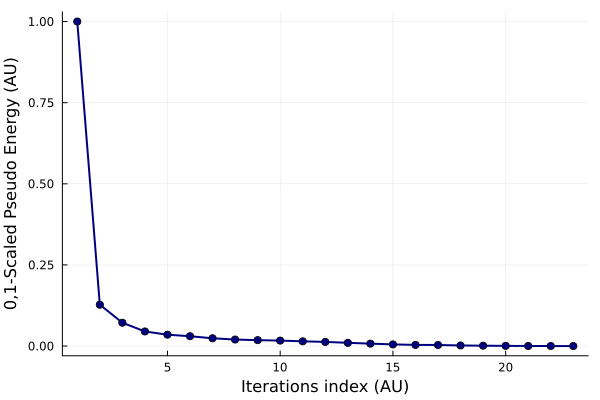

In [15]:
let
    plot(energy_array[:,1],energy_array[:,2], lw=2, c=:navy, label="") 
    scatter!(energy_array[:,1], energy_array[:,2], c=:navy, label="")
    xlabel!("Iterations index (AU)", fontsize=18)
    ylabel!("0,1-Scaled Pseudo Energy (AU)", fontsize=18)
end

___

## Task 2: Interpret cluster composition
In this task, let's analyze the contents of each cluster. Specify the cluster to examine in `my_cluster_index::Int64` where `my_cluster_index` $\in\left\{1,2,\dots,K\right\}$.

In [16]:
my_cluster_index = 3; # i ∈ {1,2,...,K}

Let's display the data for all patients in the selected cluster as a table [using the `PrettyTables.jl` package](https://github.com/ronisbr/PrettyTables.jl).

> __What should we look for?__
> 
> Patients in the same cluster should have similar feature values based on Euclidean distance in the normalized space. However, several subtleties affect our interpretation:
> 
> * __Feature weighting:__ The distance metric treats all features equally. Clusters may be tight in some dimensions while showing variance in others.
> * __Normalization effects:__ Z-scored continuous features (age, serum levels) have equal variance, while binary features (-1,1) contribute differently to distance calculations.
> * __Clinical outcome correlation:__ The `death_event` label was excluded from clustering. Thus, we are testing whether feature similarity corresponds to clinical outcomes by examining the death rate within each cluster.
> * __Centroid interpretation:__ The centroid represents the average feature profile, but individual patients can deviate. Look for patterns in which features drive cluster separation and whether clusters show homogeneous outcomes.

What do we see?

In [17]:
let

    # names - 
    names_dictionary = Dict{String,Int}();
    loopcounter = 1;
    for name ∈ names(dataset)
        names_dictionary[name] = loopcounter;
        loopcounter += 1;
    end

    df = DataFrame(); 
    assignment = result.assignments;
    index_array = findall(a -> a == my_cluster_index, assignment);

    for i ∈ eachindex(index_array)
        a = index_array[i]; # what is the assignment
        row_df = (
            c = my_cluster_index,
            id = a, # proxy for patient id?
            age = D[a,names_dictionary["age"]],
            gender = D[a,names_dictionary["sex"]],
            high_blood_pressure = D[a,names_dictionary["high_blood_pressure"]],
            serum_sodium = D[a,names_dictionary["serum_sodium"]],
            serum_creatinine = D[a, names_dictionary["serum_creatinine"]],
            ejection_fraction = D[a, names_dictionary["ejection_fraction"]],
            smoking = D[a,names_dictionary["smoking"]],
            death = dataset[a, :death_event] # this was NOT included in the cluster dataset D
        );
        push!(df, row_df);
    end
    
    pretty_table(
        df;
        backend = :text,
        fit_table_in_display_horizontally = false,
        table_format = TextTableFormat(borders = text_table_borders__compact)
    );
end

 ------- ------- ------------ --------- --------------------- -------------- ------------------ ------------------- --------- -------
      c      id          age    gender   high_blood_pressure   serum_sodium   serum_creatinine   ejection_fraction   smoking   death 
  Int64   Int64      Float64   Float64               Float64        Float64            Float64             Float64   Float64   Int64 
 ------- ------- ------------ --------- --------------------- -------------- ------------------ ------------------- --------- -------
      3      10       1.6113       1.0                   1.0      -0.821629            7.73905           -0.260554       1.0       1
      3      11      1.19095       1.0                   1.0       -1.27489            2.51918         -0.00706491       1.0       1
      3      29    -0.238246       1.0                  -1.0      -0.594999            4.25914         -0.00706491      -1.0       1
      3      49       1.6113       1.0                   1.0     

Let's view the centroid (feature averages) for the selected cluster:

In [18]:
let

    # names - 
    names_dictionary = Dict{String,Int}();
    loopcounter = 1;
    for name ∈ names(dataset)
        names_dictionary[name] = loopcounter;
        loopcounter += 1;
    end

    # for this cluster configuration, what is the death centroid?
    tmp = 0.0;
    idx_cluster = findall(x-> x == my_cluster_index, result.assignments);
    N = length(idx_cluster);
    for i ∈ idx_cluster
        tmp += dataset[i,:death_event];
    end
    death_centroid = (1/N)*tmp;
    
    μ = result.centroids[my_cluster_index]
    df = DataFrame();
    row_df = (
        c = my_cluster_index,
        age = μ[names_dictionary["age"]],
        gender = μ[names_dictionary["sex"]],
        high_blood_pressure = μ[names_dictionary["high_blood_pressure"]],
        serum_sodium = μ[names_dictionary["serum_sodium"]],
        serum_creatinine = μ[names_dictionary["serum_creatinine"]],
        ejection_fraction = μ[names_dictionary["ejection_fraction"]],
        smoking = μ[names_dictionary["smoking"]],
        death = death_centroid,
    );
    push!(df, row_df);
    
    pretty_table(
        df;
        backend = :text,
        fit_table_in_display_horizontally = false,
        table_format = TextTableFormat(borders = text_table_borders__compact)
    );
end

 ------- ---------- ---------- --------------------- -------------- ------------------ ------------------- ----------- ----------
      c        age     gender   high_blood_pressure   serum_sodium   serum_creatinine   ejection_fraction     smoking      death 
  Int64    Float64    Float64               Float64        Float64            Float64             Float64     Float64    Float64 
 ------- ---------- ---------- --------------------- -------------- ------------------ ------------------- ----------- ----------
      3   0.415634   0.333333             -0.111111      -0.519455            4.47395            0.283978   -0.555556   0.555556
 ------- ---------- ---------- --------------------- -------------- ------------------ ------------------- ----------- ----------


___

## Summary
This lab applied K-means clustering to a heart disease dataset, validating convergence through energy minimization and analyzing cluster composition to identify patient risk patterns.

> __Key Takeaways:__
> 
> * **Feature preprocessing standardizes data:** Z-score normalization of continuous features and binary recoding of categorical features to {-1,1} prepare data for distance-based clustering.
> * **Energy minimization confirms convergence:** The sum of squared distances between data points and cluster centroids decreases monotonically during iteration, verifying convergence to a stable assignment.
> * **Cluster analysis identifies risk patterns:** Examining centroid values and cluster membership reveals patient subgroups with similar risk factor profiles, enabling investigation of feature-outcome relationships.

K-means clustering provides a data-driven approach to stratify patients based on clinical features.
___